In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import bioframe 
import pandas as pd
import numpy as np 
import os
import json
from io import StringIO
import seaborn as sns
import akita_utils 
import pysam
import h5py
genome_fasta = '/project/fudenber_735/genomes/mm10/mm10.fa'
genome_open = pysam.Fastafile('/project/fudenber_735/genomes/mm10/mm10.fa')

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow as tf
print(tf.__version__)

import pysam
from basenji import dataset, seqnn, dna_io,stream
head_i = 1 #mouse
model_num = 1 #which fold to use

base_dir = '/project/fudenber_735/tensorflow_models/akita/v2/models/'
model_dir = base_dir+"/f"+str(model_num)+"c0/train/"
model_file  = model_dir+'/model'+str(head_i)+'_best.h5'

params_file = model_dir+'/params.json'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']
seq_length = params_model['seq_length']
params_model['verbose'] = False
seqnn_model = seqnn.SeqNN(params_model)
print('built')
seqnn_model.restore(model_file, head_i=head_i)
print('restored')

hic_diags = params_model['diagonal_offset']
try:
    target_crop = params_model['trunk'][-2]['cropping']
except:
    target_crop = params_model['target_crop']
target_length_cropped = int((seq_length//2048 - target_crop*2 - hic_diags)* ((seq_length//2048 - target_crop*2 - hic_diags) +1)/2) 
target_map_size = seq_length//2048  - target_crop*2 
triu_tup = np.triu_indices(target_map_size,2)
target_map_size, target_length_cropped, triu_tup[0].shape

2.4.1


2022-06-22 21:30:31.891454: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1310720, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1310720, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1310720, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1310720, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

(512, 130305, (130305,))

# Fetching chromosome data to explore background creation

In [3]:
chromsizes = bioframe.read_chromsizes('/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced')
bins = bioframe.binnify(chromsizes, 1310720)
df = bioframe.frac_gc(bins, bioframe.load_fasta('/project/fudenber_735/genomes/mm10/mm10.fa'), return_input=True)
df

,chrom,start,end,GC
0,chr1,0,1310720,NaN
1,chr1,1310720,2621440,NaN
2,chr1,2621440,3932160,0.386460
3,chr1,3932160,5242880,0.401122
4,chr1,5242880,6553600,0.393862
...,...,...,...,...
2085,chrY,86507520,87818240,0.392786
2086,chrY,87818240,89128960,0.390694
2087,chrY,89128960,90439680,0.384166
2088,chrY,90439680,91744698,0.417601


In [4]:
# df.iloc[6][['chrom','start','end','GC']]
# plt.hist( df['GC'].values, 100);
# np.percentile(df['GC'].dropna().values, np.linspace(1,99,50))

# Generating a sample for down stream analysis

In [5]:
sample_set = []
error = 0.01

for gc in np.percentile(df['GC'].dropna().values, np.linspace(1,99,50)):
    for i in range(df.shape[0]):
        if gc-error <= df['GC'].values[i] <= gc+error:
            sample_set += [i]
            break

# print(set(sample_set), len(set(sample_set)))

sample_set = list(set(sample_set))

sample_set = sample_set[2:4]
shuffle_set = [2,4,8]
print(sample_set)

[6, 7]


# Before masking

In [6]:
scores_before = {}
for gc in sample_set:
    for k in [2,4,8]:

        scores_before[gc,k] = akita_utils.custom_calculate_scores(seqnn_model=seqnn_model, 
                                                            genome_fasta=genome_fasta, 
                                                            seq_length=seq_length, 
                                                            dataframe=df, 
                                                            sample_set=[sample_set[sample_set.index(gc)]], 
                                                            max_iters = 5, 
                                                            batch_size = 20, 
                                                            shuffle_k = k, 
                                                            ctcf_thresh = 8, 
                                                            scores_thresh = 5500, 
                                                            scores_pixelwise_thresh = .04)

6
ind 6 , iter  0 ,k  2 , for chr1 7864320 9175040


2022-06-22 21:31:11.586879: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-22 21:31:11.587468: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2594900000 Hz
2022-06-22 21:31:12.390393: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13421772800 exceeds 10% of free system memory.


ind 6 , iter  1 ,k  2 , for chr1 7864320 9175040


2022-06-22 21:31:28.842005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13421772800 exceeds 10% of free system memory.


ind 6 , iter  2 ,k  2 , for chr1 7864320 9175040


2022-06-22 21:31:45.319805: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13421772800 exceeds 10% of free system memory.


ind 6 , iter  3 ,k  2 , for chr1 7864320 9175040


2022-06-22 21:32:01.849803: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13421772800 exceeds 10% of free system memory.


ind 6 , iter  4 ,k  2 , for chr1 7864320 9175040


2022-06-22 21:32:18.452029: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 13421772800 exceeds 10% of free system memory.


max iters exceeded
6
ind 6 , iter  0 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  1 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  2 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  3 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  4 ,k  4 , for chr1 7864320 9175040
max iters exceeded
6
ind 6 , iter  0 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  1 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  2 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  3 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  4 ,k  8 , for chr1 7864320 9175040
max iters exceeded
7
ind 7 , iter  0 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  1 ,k  2 , for chr1 9175040 10485760


/home1/kamulege/.conda/envs/basenji-gpu/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


ind 7 , iter  2 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  3 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  4 ,k  2 , for chr1 9175040 10485760
max iters exceeded
7
ind 7 , iter  0 ,k  4 , for chr1 9175040 10485760
ind 7 , iter  1 ,k  4 , for chr1 9175040 10485760
ind 7 , iter  2 ,k  4 , for chr1 9175040 10485760
ind 7 , iter  3 ,k  4 , for chr1 9175040 10485760
ind 7 , iter  4 ,k  4 , for chr1 9175040 10485760
max iters exceeded
7
ind 7 , iter  0 ,k  8 , for chr1 9175040 10485760
ind 7 , iter  1 ,k  8 , for chr1 9175040 10485760
ind 7 , iter  2 ,k  8 , for chr1 9175040 10485760
ind 7 , iter  3 ,k  8 , for chr1 9175040 10485760
ind 7 , iter  4 ,k  8 , for chr1 9175040 10485760
max iters exceeded


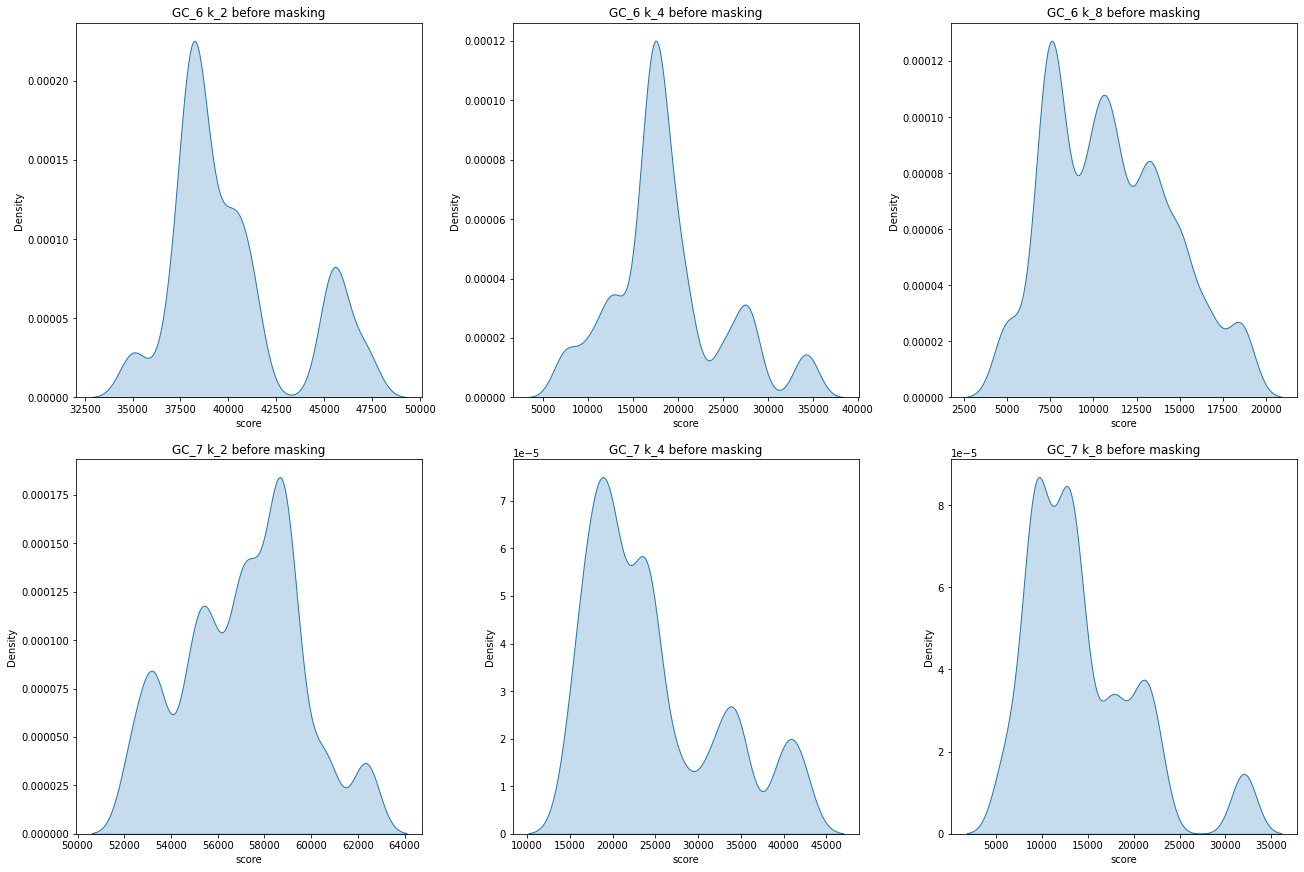

In [7]:

fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)
           
for gc in sample_set:
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(gc),shuffle_set.index(k)])
        # plt.hist(scores_before[gc,k],10)
        
        kde_df = pd.DataFrame(scores_before[gc,k], columns=["score"])
        sns.kdeplot(data=kde_df, x="score", bw_adjust=.4, fill=True)
        
        plt.title(f'GC_{gc} k_{k} before masking')
plt.show()
plt.close()

# After masking

In [8]:
scores_after = {}
for gc in sample_set:
    for k in [2,4,8]:

        scores_after[gc,k] = akita_utils.custom_calculate_scores(seqnn_model=seqnn_model, 
                                                            genome_fasta=genome_fasta, 
                                                            seq_length=seq_length, 
                                                            dataframe=df, 
                                                            sample_set=[sample_set[sample_set.index(gc)]], 
                                                            max_iters = 5, 
                                                            batch_size = 20, 
                                                            shuffle_k = k, 
                                                            ctcf_thresh = 8, 
                                                            scores_thresh = 5500, 
                                                            scores_pixelwise_thresh = .04,
                                                            masking = True)

6
ind 6 , iter  0 ,k  2 , for chr1 7864320 9175040
ind 6 , iter  1 ,k  2 , for chr1 7864320 9175040
ind 6 , iter  2 ,k  2 , for chr1 7864320 9175040
ind 6 , iter  3 ,k  2 , for chr1 7864320 9175040
ind 6 , iter  4 ,k  2 , for chr1 7864320 9175040
max iters exceeded
6
ind 6 , iter  0 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  1 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  2 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  3 ,k  4 , for chr1 7864320 9175040
ind 6 , iter  4 ,k  4 , for chr1 7864320 9175040
max iters exceeded
6
ind 6 , iter  0 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  1 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  2 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  3 ,k  8 , for chr1 7864320 9175040
ind 6 , iter  4 ,k  8 , for chr1 7864320 9175040
max iters exceeded
7
ind 7 , iter  0 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  1 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  2 ,k  2 , for chr1 9175040 10485760
ind 7 , iter  3 ,k  2 , for chr1 9175040 10485760


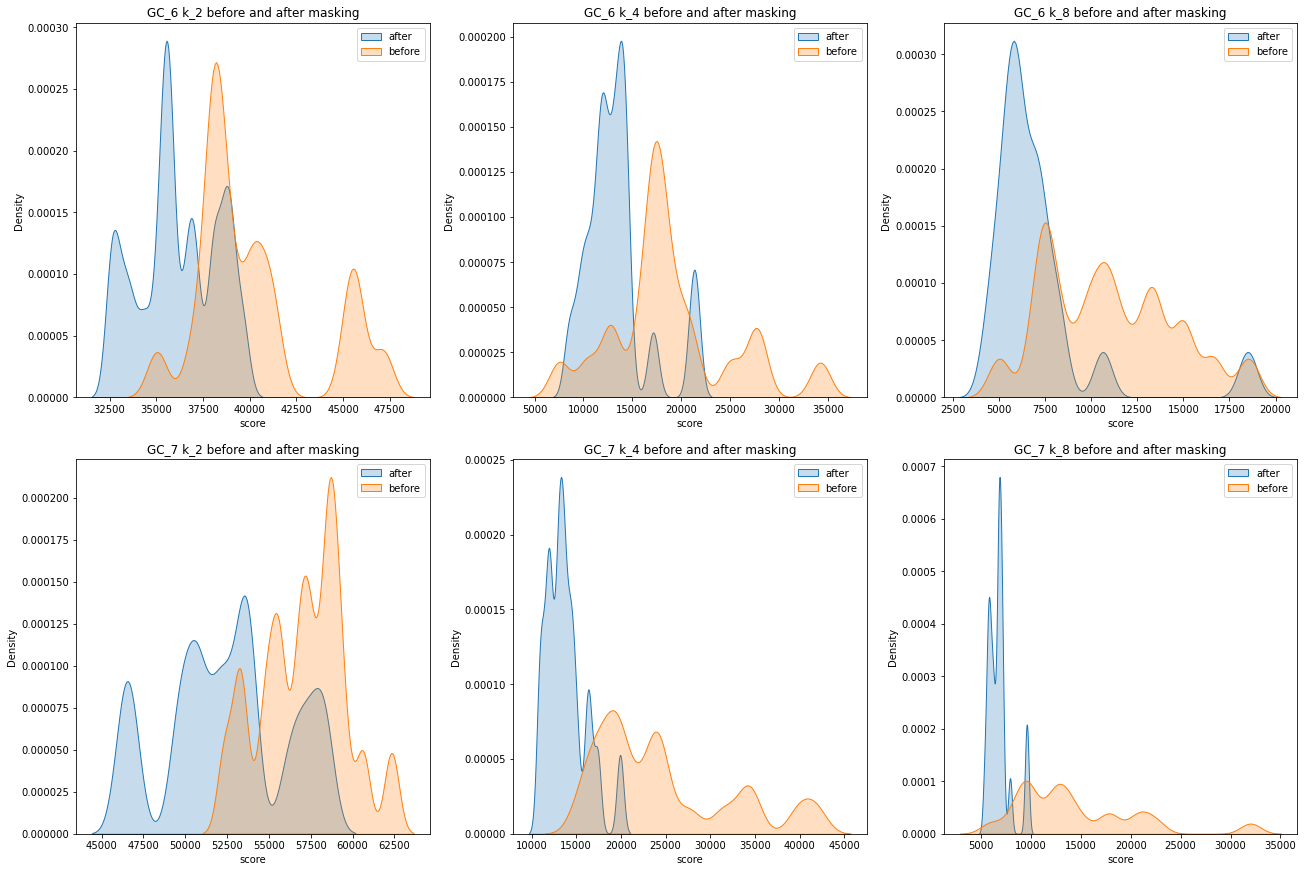

In [9]:
fig = plt.figure(figsize=(6* len(shuffle_set) , 6 *  len(sample_set) ), constrained_layout=True)     
spec = fig.add_gridspec(ncols=len(shuffle_set), nrows=len(sample_set), hspace=0.1, wspace=0.1)#
           
for gc in sample_set:
    for k in shuffle_set:
        ax1 = fig.add_subplot(spec[sample_set.index(gc),shuffle_set.index(k)])
        # plt.hist(scores_after[gc,k],5)
        
        kde_df_before = pd.DataFrame(scores_before[gc,k], columns=["score"])
        kde_df_after = pd.DataFrame(scores_after[gc,k], columns=["score"])
        sns.kdeplot(data=kde_df_after, x="score", bw_adjust=.3, label='after', fill=True)
        sns.kdeplot(data=kde_df_before, x="score", bw_adjust=.3, label='before', fill=True)
        plt.legend()
        plt.title(f'GC_{gc} k_{k} before and after masking')
plt.show()
plt.close()